In [ ]:
# restart notebook to  use dark theme
#!pip install jupyterthemes
#!jt -t chesterish

# !pip install imageio Pillow

In [ ]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [ ]:
import numpy as np
import os

_proj_dir = '/content/drive/My Drive/reflect_gan/'
_save_dir = '/tmp/'
_chairs_dir = _proj_dir + 'datasets/chairs/'
_img_dirs = [('','reflect'), ('object/','object'), ('depth/','depth')]
_prep_dir = _proj_dir + 'prep/'
_specs = [('train', 0.7), ('valid', 0.2), ('test', 0.1)]
_shuffle_size = 100
_batch_size = 1
_h = 256
_w = 128
_epoch_per_ckpt = 100
_epoch_count = 1000

def _mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise

def _remove_file(filename):
    if os.path.isfile(filename):
        os.remove(filename)

# Based on: https://stackoverflow.com/questions/36960320/convert-a-2d-matrix-to-a-3d-one-hot-matrix-numpy
def _onehot_numpy_ndarray(a):
    ncols = a.max().astype(int)+1
    out = np.zeros( (a.size,ncols))
    out[np.arange(a.size),a.ravel()] = 1
    out.shape = a.shape + (ncols,)
    return out

def _plot_img(img, vmin=None, vmax=None, cmap='gray'):
    plt.figure()
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.show()
    
def _np_floats_feat(np_array):
    return tf.train.Feature( float_list=tf.train.FloatList( value=np_array.flatten().tolist()))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
from PIL import Image


[train] dataset element_spec: (TensorSpec(shape=(256, 128), dtype=tf.float32, name=None), TensorSpec(shape=(256, 128), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.float32, name=None))


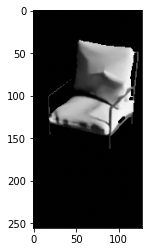

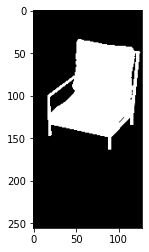

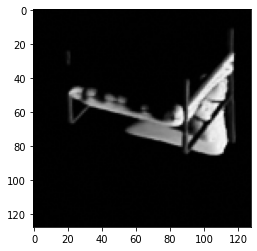

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def parse_func(example_proto):
    feats_spec = { x: tf.io.FixedLenFeature( [_h, _w], tf.float32) for _, x in _img_dirs}
    feats_spec['isObj'] =  tf.io.FixedLenFeature( [_h, _w], tf.float32)
    parsed_feats = tf.io.parse_single_example( example_proto, feats_spec)
    
    return parsed_feats['object'], parsed_feats['isObj'], parsed_feats['reflect'][128:,:]

def input_fn_from_type(string):
    raw_dataset = tf.data.TFRecordDataset( _prep_dir+string+'.tfrecords')
    dataset = raw_dataset.map( parse_func)
    print('[{:>5}] dataset element_spec: {}'.format(string, dataset.element_spec))
    dataset = dataset.shuffle(buffer_size=_shuffle_size)
    dataset = dataset.batch(_batch_size)
    
    return dataset

for x in input_fn_from_type('train').as_numpy_iterator():
    [ _plot_img( y[0]) for y in x]
    break


In [ ]:
from tensorflow.keras import Input, initializers, Model
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

def reflect_net():
    obj_img = Input([_h, _w])
    is_obj_img = Input([_h, _w])

    # Object detection
    reshape_img1 = L.Reshape([_h, _w, 1])(obj_img)
    feat_img11 = L.Conv2D(16, [3,3], padding='same', activation='relu', use_bias=True)(reshape_img1)
    pool_img11 = L.MaxPooling2D([2,2])(feat_img11)
    feat_img12 = L.Conv2D(32, [3,3], padding='same', activation='relu', use_bias=True)(pool_img11)
    pool_img12 = L.MaxPooling2D([2,2])(feat_img12)
    feat_img13 = L.Conv2D(64, [3,3], padding='same', activation='relu', use_bias=True)(pool_img12)
    pool_img13 = L.MaxPooling2D([2,2])(feat_img13)
    feat_img14 = L.Conv2D(64, [3,3], padding='same', activation='relu', use_bias=True)(pool_img13)
    pool_img14 = L.Lambda(lambda x: tf.nn.pool( x, [2,2], pooling_type='MAX', strides=[1,1], padding='SAME'))(feat_img14)
    feat_img15 = L.Conv2D(64, [3,3], dilation_rate=[2,2], padding='same', activation='relu', use_bias=True, 
                          kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.2))(pool_img14)
    pool_img15 = L.Lambda(lambda x: tf.nn.pool( tf.pad(x, [[0,0], [1,1], [1,1], [0,0]], "CONSTANT", constant_values=0),
                                               [2,2], pooling_type='MAX', strides=[1,1], dilations=[2,2], padding='VALID'))(feat_img15)
    feat_img16 = L.Conv2D(64, [3,3], dilation_rate=[4,4], padding='same', activation='relu', use_bias=True, 
                          kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.3))(pool_img15)
    
    # Shallow features
    feat1_img21 = L.AveragePooling2D([8,8])(reshape_img1)
    feat1_img22 = L.Conv2D(128, [8,8], padding='same', activation='relu', use_bias=True, 
                           kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.4))(feat1_img21)
    # Merge object detection and shallow features
    feat1_img23 = L.Dense(128, activation=None, use_bias=False)(feat1_img22)
    class_img21 = L.Dense(128, activation=None, use_bias=False)(feat_img16)
    pos_img21 = L.Add()([feat1_img23, class_img21])
    # Dense reduce features
    pos_img22 = L.Activation('tanh')(pos_img21)
    pos_img23 = L.Dense(128, activation='tanh', use_bias=True)(pos_img22)
    pos_img24 = L.Dense(64, activation='tanh', use_bias=True)(pos_img23)
    pos_img25 = L.Dense(16, activation='sigmoid', use_bias=True)(pos_img24)
    # Only use features from non-dark areas of image
    reshape_img2 = L.Reshape([_h, _w, 1])(is_obj_img)
    gate_img21 = L.MaxPooling2D([8,8])(reshape_img2)
    gate_img22 = L.Lambda(lambda x: tf.reshape( tf.repeat(x, 16), [-1, _h//8, _w//8, 16]))(gate_img21)
    pos_img26 = L.Multiply()([gate_img22, pos_img25])
    
    # Get 8*8-downsampled features image
    feat_img31 = L.Dense(64, activation='sigmoid', use_bias=True)(pool_img13)
    feat_img32 = L.Dense(64, activation='sigmoid', use_bias=True)(feat_img31)
    # Distribute features by postion
    feat_blk31 = L.Lambda(lambda x: tf.reshape( tf.tile(x, [1,1,1,16]), [-1, _h//8, _w//8, 16, 64]))(feat_img32)
    pos_blk31 = L.Lambda(lambda x: tf.reshape( tf.repeat(x, 64), [-1, _h//8, _w//8, 16, 64]))(pos_img26)
    feat_blk32 = L.Multiply()([feat_blk31, pos_blk31])
    feat_img33 = L.Lambda(lambda x: tf.transpose( tf.reduce_sum(x,  axis=1), perm=[0,2,1,3]))(feat_blk32)
    # Reconstruct image
    feat_img34 = L.Dense(64, activation='sigmoid', use_bias=True)(feat_img33)
    feat_img35 = L.Conv2DTranspose(32, [3,3], strides=[2,2], padding='same', activation='relu', use_bias=True)(feat_img34)
    feat_img36 = L.Conv2DTranspose(16, [3,3], strides=[2,2], padding='same', activation='relu', use_bias=True)(feat_img35)
    feat_img37 = L.Conv2DTranspose(1, [3,3], strides=[2,2], padding='same', activation='relu', use_bias=True)(feat_img36)
    
    return Model(inputs=[obj_img, is_obj_img], outputs=L.Lambda( lambda x: tf.squeeze( x, axis=[-1]))( feat_img37))

reflect_net().summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 128)]   0                                            
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 256, 128, 1)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 128, 16) 160         reshape_8[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 128, 64, 16)  0           conv2d_28[0][0]                  
____________________________________________________________________________________________

[train] dataset element_spec: (TensorSpec(shape=(256, 128), dtype=tf.float32, name=None), TensorSpec(shape=(256, 128), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128), dtype=tf.float32, name=None))


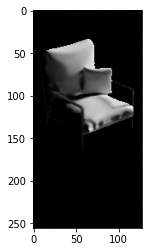

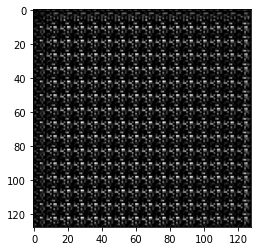

tf.Tensor(
[[0.0274 0.0057 0.     ... 0.0335 0.0159 0.0202]
 [0.0017 0.0052 0.     ... 0.     0.     0.    ]
 [0.     0.0062 0.0218 ... 0.0692 0.0186 0.0069]
 ...
 [0.     0.     0.     ... 0.     0.0364 0.    ]
 [0.0185 0.0511 0.     ... 0.     0.     0.    ]
 [0.0119 0.02   0.     ... 0.0208 0.     0.    ]], shape=(128, 128), dtype=float32)
0.1939795
0.0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=4)
for x in input_fn_from_type('train').as_numpy_iterator():
    chk_output = (reflect_net()( [x[0], x[1]], training=False))[0]
    #chk_output2 = (reflect_net()( [x[0], x[1]], training=False))[0][:,:,1]
    #chk_output = (reflect_net()( [x[0], x[1]], training=False))[0][118:138,54:64,0]
    #chk_output = (reflect_net()( [x[0], x[1]], training=False))[0][12,8:10,:]
    max = np.max(chk_output)
    #min = np.min(chk_output[chk_output > 0])
    min = np.min(chk_output)
    #_plot_img( chk_output, min, max)
    _plot_img( x[0][0])
    _plot_img( chk_output)
    #_plot_img( chk_output2)
    print( chk_output)
    print( max)
    print( min)
    break

In [ ]:
reflect_net().trainable_variables

[<tf.Variable 'conv2d_42/kernel:0' shape=(3, 3, 1, 16) dtype=float32, numpy=
 array([[[[-0.1088, -0.1337,  0.0489, -0.0516,  0.0999, -0.1549,
            0.1578, -0.1847, -0.0237, -0.1767,  0.0895, -0.071 ,
            0.0356, -0.0018,  0.1711, -0.0943]],
 
         [[-0.0303,  0.0092,  0.0756,  0.1709,  0.082 ,  0.14  ,
            0.1246,  0.1699,  0.1517, -0.1928,  0.0145, -0.0615,
           -0.1251, -0.0192,  0.1165, -0.1751]],
 
         [[ 0.0967, -0.1854,  0.0282,  0.1892, -0.0403,  0.0981,
           -0.0634, -0.0262,  0.1375, -0.0539,  0.1391, -0.0098,
            0.1228, -0.1345, -0.1377, -0.1244]]],
 
 
        [[[ 0.0702, -0.0947,  0.0544, -0.0573, -0.0306, -0.1471,
           -0.0032,  0.0134, -0.0665, -0.0712, -0.01  ,  0.0801,
            0.0344,  0.03  , -0.1502, -0.1419]],
 
         [[ 0.176 ,  0.1801,  0.1161,  0.1939, -0.1093, -0.1782,
           -0.1923, -0.0629,  0.0493,  0.0344,  0.1918, -0.1435,
           -0.0679, -0.0842, -0.1562, -0.1606]],
 
         [[ 0.0

In [ ]:
import os
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy

mse = tf.keras.losses.MeanSquaredError()
optimizer = SGD(lr=0.01, clipvalue=0.5)

checkpoint_dir = _save_dir + 'ckpts/'
_mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
keras_model = reflect_net()
checkpoint = tf.train.Checkpoint(SGD=optimizer, reflect_net=keras_model)

import datetime

log_dir = _save_dir + "logs/"
_mkdir(log_dir)
summary_writer = tf.summary.create_file_writer(
    log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(obj_imgs, is_obj_imgs, target_imgs, epoch):
    with tf.GradientTape() as gen_tape:
        prediction = keras_model([obj_imgs, is_obj_imgs], training=True)
        loss = mse(y_true=target_imgs, y_pred=prediction)
        gradients = gen_tape.gradient(loss, keras_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, keras_model.trainable_variables))

        print (loss)

    with summary_writer.as_default():
        tf.summary.scalar('loss', loss, step=epoch)

        
import time
from IPython.display import clear_output

def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        
        clear_output(wait=True)
        chk_sample = [x for x in test_ds.take(1)][0]
        chk_output = keras_model([chk_sample[0], chk_sample[1]], training=False)
        _plot_img(chk_output.numpy()[0])
        _plot_img(chk_sample[2][0])
        print("Epoch: ", epoch)

        # Train
        for i, (x0, x1, y) in train_ds.enumerate():
            if (i+1) % 100 == 0:
                print('.', end='')
            train_step(x0, x1, y, epoch)
        print()

        # saving (checkpoint) the model every n epochs
        if (epoch + 1) % _epoch_per_ckpt == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))
    checkpoint.save(file_prefix = checkpoint_prefix)

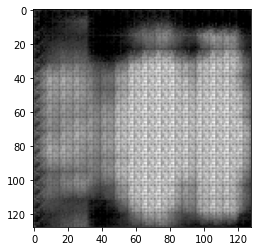

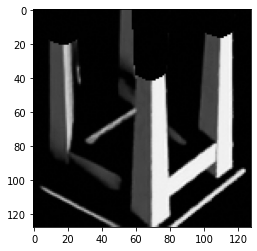

Epoch:  36
Tensor("mean_squared_error/weighted_loss/value:0", shape=(), dtype=float32)
........

In [ ]:
fit(input_fn_from_type('train'), _epoch_count, input_fn_from_type('test'))